In [1]:
PATH = 'D:/Code/altruistic-req-class/'

from tqdm import tqdm
import json
import pandas as pd
import numpy as np
from statistics import mean
from prettytable import PrettyTable

import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

np.set_printoptions(suppress=True)

In [2]:
# certificate verification fail

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siddh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\siddh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\siddh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
with open(PATH + 'pizza_request_dataset/pizza_request_dataset.json', 'r') as f:
    data = json.load(f)

In [5]:
len(data)

5671

In [6]:
sorted(data[0].keys())

['giver_username_if_known',
 'in_test_set',
 'number_of_downvotes_of_request_at_retrieval',
 'number_of_upvotes_of_request_at_retrieval',
 'post_was_edited',
 'request_id',
 'request_number_of_comments_at_retrieval',
 'request_text',
 'request_text_edit_aware',
 'request_title',
 'requester_account_age_in_days_at_request',
 'requester_account_age_in_days_at_retrieval',
 'requester_days_since_first_post_on_raop_at_request',
 'requester_days_since_first_post_on_raop_at_retrieval',
 'requester_number_of_comments_at_request',
 'requester_number_of_comments_at_retrieval',
 'requester_number_of_comments_in_raop_at_request',
 'requester_number_of_comments_in_raop_at_retrieval',
 'requester_number_of_posts_at_request',
 'requester_number_of_posts_at_retrieval',
 'requester_number_of_posts_on_raop_at_request',
 'requester_number_of_posts_on_raop_at_retrieval',
 'requester_number_of_subreddits_at_request',
 'requester_received_pizza',
 'requester_subreddits_at_request',
 'requester_upvotes_minus

In [7]:
success = [d['requester_received_pizza'] for d in data]
print("Average Success Rate",str(sum(success)/len(success)*100))

Average Success Rate 24.634103332745546


In [8]:
for d in data:
    d['upvotes_minus_downvotes'] = d['number_of_upvotes_of_request_at_retrieval'] - d['number_of_downvotes_of_request_at_retrieval']

for d in data:
    d['final_request_text'] = d['request_title'] + " " + d['request_text_edit_aware']

In [9]:
data[0]

{'giver_username_if_known': 'N/A',
 'in_test_set': False,
 'number_of_downvotes_of_request_at_retrieval': 2,
 'number_of_upvotes_of_request_at_retrieval': 6,
 'post_was_edited': False,
 'request_id': 't3_w5491',
 'request_number_of_comments_at_retrieval': 7,
 'request_text': "I'm not in College, or a starving artist or anything like that. I've just been a bit unlucky lately. I'm a 36 year old single guy with a job. But rent, and other bills killed me this month. I thought I had enough funds in my account to at least keep me set with Mr. Noodles, I forgot about my monthly banking fee.\n\nI had a small bag of chips Wednesday afternoon, and I get paid Monday, so I'll be fine then.. It's just really painful at this point and food is something I'm constantly thinking about.\n\nI've got a few bucks to get on the bus to work on Saturday, so I can't really use that.\n\nI'm really embarrassed to even be asking like this and I'm not sure how it works, so please be patient with me.\n\nI guess tha

In [10]:
df = pd.json_normalize(data)
df['requester_received_pizza'] = df['requester_received_pizza'].astype(int)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,giver_username_if_known,in_test_set,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,...,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,upvotes_minus_downvotes,final_request_text
0,N/A,True,1,5,False,t3_mqngj,1,I know I've been helped before but I've gotten...,I know I've been helped before but I've gotten...,"[Request] Canadian student, up coming exams, b...",...,91,93,143,147,shroom,InGenUse,1.322376e+09,1.322376e+09,4,"[Request] Canadian student, up coming exams, b..."
1,N/A,True,1,7,True,t3_k025c,2,"[EDIT] I live in Mesa, AZ 85201 &lt;- thanks t...","[EDIT] I live in Mesa, AZ 85201 &lt;- thanks t...",[REQUEST] Student - job went through the crapper,...,637,6486,3345,21108,None,williambueti,1.314790e+09,1.314787e+09,6,[REQUEST] Student - job went through the crapp...
2,N/A,False,4,7,1375744673.0,t3_1jr1qq,1,Life is rough as is but especially when your j...,Life is rough as is but especially when your j...,[Request] Job shorted my last paycheck. Get pa...,...,2145,2491,3553,4029,shroom,20TL12III,1.375727e+09,1.375723e+09,3,[Request] Job shorted my last paycheck. Get pa...
3,N/A,False,1,1,False,t3_j4gi2,0,my family is away on vacation. I have three do...,my family is away on vacation. I have three do...,[REQUEST] redditor in pa wants pizza,...,255,839,553,1899,None,xl_Ruthless_lx,1.312074e+09,1.312070e+09,0,[REQUEST] redditor in pa wants pizza my family...
4,N/A,True,3,13,False,t3_iwavb,5,I'm 20 and live on my own. I'm not poor or nec...,I'm 20 and live on my own. I'm not poor or nec...,[Request] Single 20 year old who lives alone a...,...,0,15,0,21,None,ikell3,1.311294e+09,1.311291e+09,10,[Request] Single 20 year old who lives alone a...


In [11]:
df['requester_received_pizza'].isna().sum()

0

In [12]:
# text preprocessing
stopwords_eng = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def process_text(text):
    text = text.replace("\n"," ").replace("\r"," ")
    text = re.sub(r'“', " '' ", text)
    text = re.sub(r'”', " '' ", text)
    text = re.sub(r'"', " '' ", text)
    text = re.sub(r'(\S)(\'\')', r'\1 \2 ', text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    punc_list = '!"#$%()*+,-./:;<=>?@^_{|}~[]'
    t = str.maketrans(dict.fromkeys(punc_list," "))
    text = text.translate(t)
    
    t = str.maketrans(dict.fromkeys("'`",""))
    text = text.translate(t)
    
    text = text.lower()
    
    tokens = regexp_tokenize(text,pattern='\s+',gaps=True)
    cleaned_tokens = []
    
    for t in tokens:
        if t not in stopwords_eng:
            l = lemmatizer.lemmatize(t)
            cleaned_tokens.append(l)
    
    return cleaned_tokens

In [13]:
process_text(df['final_request_text'][0])

['request',
 'canadian',
 'student',
 'coming',
 'exam',
 'bill',
 'bank',
 'know',
 'going',
 'pay',
 'know',
 'helped',
 'gotten',
 'situation',
 'extremely',
 'stressed',
 'job',
 'right',
 'sick',
 'ramen',
 'would',
 'really',
 'appreciate',
 'someone',
 'could',
 'lessen',
 'burden',
 'cheering',
 'bit',
 'promise',
 'would',
 'able',
 'pay',
 'forward',
 'thank']

In [14]:
text_data = df[['final_request_text','requester_received_pizza']]
text_data.head(10)

,final_request_text,requester_received_pizza
0,"[Request] Canadian student, up coming exams, b...",1
1,[REQUEST] Student - job went through the crapp...,0
2,[Request] Job shorted my last paycheck. Get pa...,1
3,[REQUEST] redditor in pa wants pizza my family...,0
4,[Request] Single 20 year old who lives alone a...,0
5,"[Request] Illinois, USA. I came down with the ...",0
6,[Request] (RI) Started a new strenuous job and...,0
7,[REQUEST OH] I live in the worst part of my to...,0
8,"[Request] East Lansing, MI. Playing beerio kar...",0
9,[Request] Looking to get a pizza for a buddy o...,0


In [37]:
# USING COUNTVECTORIZER TO CONVERT TEXT INTO VECTOR

count_vec = CountVectorizer(analyzer = process_text)
count_df = count_vec.fit_transform(text_data['final_request_text'])
count_labels = text_data['requester_received_pizza']

print(count_df.shape)

# count_df vs count_labels [different models]

(5671, 14297)


In [38]:
count_df

<5671x14297 sparse matrix of type '<class 'numpy.int64'>'
	with 226091 stored elements in Compressed Sparse Row format>

In [39]:
count_df[0].shape

(1, 14297)

In [40]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

skfold_count = StratifiedKFold(n_splits = 10)
count_model_lr = LogisticRegression()
count_model_nbg = GaussianNB()
count_model_nbm = MultinomialNB()
count_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

count_model_lr_accuracy_score = []
count_model_nbg_accuracy_score = []
count_model_nbm_accuracy_score = []
count_model_rf_accuracy_score = []

count_model_lr_precision_score = []
count_model_nbg_precision_score = []
count_model_nbm_precision_score = []
count_model_rf_precision_score = []

count_model_lr_recall_score = []
count_model_nbg_recall_score = []
count_model_nbm_recall_score = []
count_model_rf_recall_score = []

count_model_lr_f1_score = []
count_model_nbg_f1_score = []
count_model_nbm_f1_score = []
count_model_rf_f1_score = []


for train_index, test_index in skfold_count.split(count_df, count_labels):
    X_train, X_test = count_df[train_index], count_df[test_index]
    y_train, y_test = count_labels[train_index], count_labels[test_index]
    
    count_model_lr.fit(X_train,y_train)
    count_model_lr_accuracy_score.append(accuracy_score(y_test,count_model_lr.predict(X_test)))
    count_model_lr_precision_score.append(precision_score(y_test,count_model_lr.predict(X_test)))
    count_model_lr_recall_score.append(recall_score(y_test,count_model_lr.predict(X_test)))
    count_model_lr_f1_score.append(f1_score(y_test,count_model_lr.predict(X_test)))
    
    count_model_nbg.fit(X_train.toarray(),y_train)
    count_model_nbg_accuracy_score.append(accuracy_score(y_test,count_model_nbg.predict(X_test.toarray())))
    count_model_nbg_precision_score.append(precision_score(y_test,count_model_nbg.predict(X_test.toarray())))
    count_model_nbg_recall_score.append(recall_score(y_test,count_model_nbg.predict(X_test.toarray())))
    count_model_nbg_f1_score.append(f1_score(y_test,count_model_nbg.predict(X_test.toarray())))
    
    count_model_nbm.fit(X_train,y_train)
    count_model_nbm_accuracy_score.append(accuracy_score(y_test,count_model_nbm.predict(X_test)))
    count_model_nbm_precision_score.append(precision_score(y_test,count_model_nbm.predict(X_test)))
    count_model_nbm_recall_score.append(recall_score(y_test,count_model_nbm.predict(X_test)))
    count_model_nbm_f1_score.append(f1_score(y_test,count_model_nbm.predict(X_test)))
    
    count_model_rf.fit(X_train,y_train)
    count_model_rf_accuracy_score.append(accuracy_score(y_test,count_model_rf.predict(X_test)))
    count_model_rf_precision_score.append(precision_score(y_test,count_model_rf.predict(X_test)))
    count_model_rf_recall_score.append(recall_score(y_test,count_model_rf.predict(X_test)))
    count_model_rf_f1_score.append(f1_score(y_test,count_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(count_model_lr_accuracy_score),mean(count_model_lr_precision_score),mean(count_model_lr_recall_score),mean(count_model_lr_f1_score)],
    ['Gaussian NB', mean(count_model_nbg_accuracy_score),mean(count_model_nbg_precision_score),mean(count_model_nbg_recall_score),mean(count_model_nbg_f1_score)],
    ['Multinomial NB', mean(count_model_nbm_accuracy_score),mean(count_model_nbm_precision_score),mean(count_model_nbm_recall_score),mean(count_model_nbm_f1_score)],
    ['Random Forest', mean(count_model_rf_accuracy_score),mean(count_model_rf_precision_score),mean(count_model_rf_recall_score),mean(count_model_rf_f1_score)],
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.7009290309759794,0.34447273980393717,0.23478931140801643,0.2787206511669151
Gaussian NB,0.4955057505526989,0.23403717607707858,0.4602877697841727,0.3102112225541277
Multinomial NB,0.7143394316516383,0.32290396410940286,0.14462487153134634,0.19954567639191756
Random Forest,0.7538356683309735,0.3,0.002147995889003083,0.0042654508611955425


In [41]:
tfidf_vec = TfidfVectorizer(analyzer = process_text)
tfidf_df = tfidf_vec.fit_transform(text_data['final_request_text'])
tfidf_labels = text_data['requester_received_pizza']

print(tfidf_df.shape)

# tfidf_df vs tfidf_labels [different models]

(5671, 14297)


In [42]:
tfidf_df[0].shape

(1, 14297)

In [56]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

skfold_tfidf = StratifiedKFold(n_splits = 10)
tfidf_model_lr = LogisticRegression()
tfidf_model_nbg = GaussianNB()
tfidf_model_nbm = MultinomialNB()
tfidf_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

tfidf_model_lr_accuracy_score = []
tfidf_model_nbg_accuracy_score = []
tfidf_model_nbm_accuracy_score = []
tfidf_model_rf_accuracy_score = []

tfidf_model_lr_precision_score = []
tfidf_model_nbg_precision_score = []
tfidf_model_nbm_precision_score = []
tfidf_model_rf_precision_score = []

tfidf_model_lr_recall_score = []
tfidf_model_nbg_recall_score = []
tfidf_model_nbm_recall_score = []
tfidf_model_rf_recall_score = []

tfidf_model_lr_f1_score = []
tfidf_model_nbg_f1_score = []
tfidf_model_nbm_f1_score = []
tfidf_model_rf_f1_score = []


for train_index, test_index in skfold_tfidf.split(tfidf_df, tfidf_labels):
    X_train, X_test = tfidf_df[train_index], tfidf_df[test_index]
    y_train, y_test = tfidf_labels[train_index], tfidf_labels[test_index]
    
    tfidf_model_lr.fit(X_train,y_train)
    tfidf_model_lr_accuracy_score.append(accuracy_score(y_test,tfidf_model_lr.predict(X_test)))
    tfidf_model_lr_precision_score.append(precision_score(y_test,tfidf_model_lr.predict(X_test)))
    tfidf_model_lr_recall_score.append(recall_score(y_test,tfidf_model_lr.predict(X_test)))
    tfidf_model_lr_f1_score.append(f1_score(y_test,tfidf_model_lr.predict(X_test)))
    
    tfidf_model_nbg.fit(X_train.toarray(),y_train)
    tfidf_model_nbg_accuracy_score.append(accuracy_score(y_test,tfidf_model_nbg.predict(X_test.toarray())))
    tfidf_model_nbg_precision_score.append(precision_score(y_test,tfidf_model_nbg.predict(X_test.toarray())))
    tfidf_model_nbg_recall_score.append(recall_score(y_test,tfidf_model_nbg.predict(X_test.toarray())))
    tfidf_model_nbg_f1_score.append(f1_score(y_test,tfidf_model_nbg.predict(X_test.toarray())))
    
    tfidf_model_nbm.fit(X_train,y_train)
    tfidf_model_nbm_accuracy_score.append(accuracy_score(y_test,tfidf_model_nbm.predict(X_test)))
    tfidf_model_nbm_precision_score.append(precision_score(y_test,tfidf_model_nbm.predict(X_test)))
    tfidf_model_nbm_recall_score.append(recall_score(y_test,tfidf_model_nbm.predict(X_test)))
    tfidf_model_nbm_f1_score.append(f1_score(y_test,tfidf_model_nbm.predict(X_test)))
    
    tfidf_model_rf.fit(X_train,y_train)
    tfidf_model_rf_accuracy_score.append(accuracy_score(y_test,tfidf_model_rf.predict(X_test)))
    tfidf_model_rf_precision_score.append(precision_score(y_test,tfidf_model_rf.predict(X_test)))
    tfidf_model_rf_recall_score.append(recall_score(y_test,tfidf_model_rf.predict(X_test)))
    tfidf_model_rf_f1_score.append(f1_score(y_test,tfidf_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(tfidf_model_lr_accuracy_score),mean(tfidf_model_lr_precision_score),mean(tfidf_model_lr_recall_score),mean(tfidf_model_lr_f1_score)],
    ['Gaussian NB', mean(tfidf_model_nbg_accuracy_score),mean(tfidf_model_nbg_precision_score),mean(tfidf_model_nbg_recall_score),mean(tfidf_model_nbg_f1_score)],
    ['Multinomial NB', mean(tfidf_model_nbm_accuracy_score),mean(tfidf_model_nbm_precision_score),mean(tfidf_model_nbm_recall_score),mean(tfidf_model_nbm_f1_score)],
    ['Random Forest', mean(tfidf_model_rf_accuracy_score),mean(tfidf_model_rf_precision_score),mean(tfidf_model_rf_recall_score),mean(tfidf_model_rf_f1_score)],
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.7526004794197283,0.5055952380952381,0.025046248715313465,0.0473914613272823
Gaussian NB,0.49920914375139724,0.23467502311942504,0.45599177800616647,0.3097904979010324
Multinomial NB,0.7536589909829347,0.0,0.0,0.0
Random Forest,0.7534826241399011,0.0,0.0,0.0


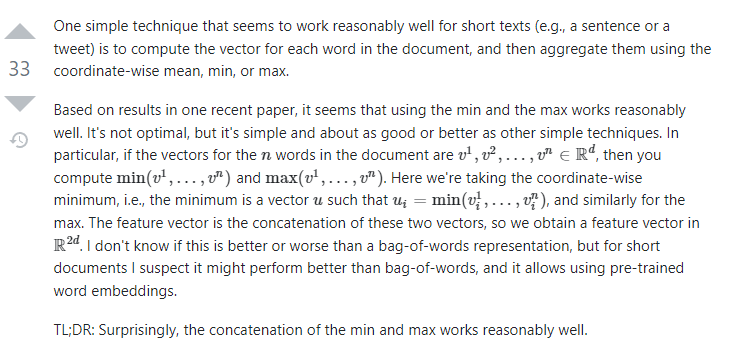

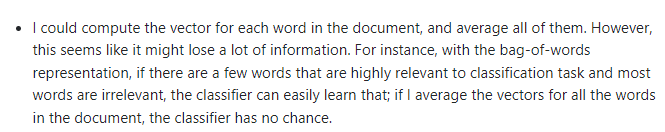

In [57]:
model = KeyedVectors.load_word2vec_format(PATH + "GoogleNews-vectors-negative300.bin", limit = 10**6,binary=True)

def get_vec(word):
    try:
        return model[word]
    except:
        return np.zeros(300)
    
def get_sent_vec_mean(sent):
    tokens = process_text(sent)
    vector = np.mean([get_vec(t) for t in tokens], axis = 0)
    
    return vector

word2vec_emb = text_data.apply(lambda r: get_sent_vec_mean(r['final_request_text']), axis=1)
v = np.column_stack([word2vec_emb.values.tolist()])
word2vec_df = pd.DataFrame(v)
word2vec_labels = text_data['requester_received_pizza']
word2vec_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.035778,0.075670,-0.009770,0.121342,-0.064047,-0.009121,0.111883,-0.040295,0.054637,0.026644,...,-0.075028,0.061651,-0.067486,0.007034,-0.052448,0.064162,-0.010371,-0.015286,0.029321,-0.053363
1,-0.001925,0.026027,0.012305,0.136249,-0.036176,0.003321,0.082402,-0.061894,0.064068,0.044783,...,-0.031779,0.060481,-0.114349,0.069205,0.000946,-0.031868,0.013233,-0.058570,-0.001518,0.004904
2,0.012049,0.019208,-0.031880,0.085555,0.005203,-0.004432,0.054494,-0.077524,0.086917,0.059034,...,0.001787,0.027977,-0.090431,0.038900,-0.033833,-0.011022,-0.054636,-0.032831,-0.005502,-0.050024
3,0.038475,-0.002934,0.014777,0.127824,-0.018820,-0.000213,0.072560,-0.088774,0.086571,0.060517,...,-0.085525,0.062439,-0.093811,0.034239,0.054970,-0.002031,-0.026576,-0.066048,-0.016090,-0.082164
4,0.044041,0.044993,0.037410,0.152907,-0.032802,0.051939,0.094786,-0.065150,0.032170,0.069673,...,-0.069800,0.040315,-0.094363,0.020573,0.021869,-0.011655,-0.012319,-0.070440,-0.001900,-0.052473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5666,0.029613,0.022932,0.043481,0.182022,-0.043031,0.010043,0.041277,-0.048334,0.016486,0.048429,...,-0.108489,0.091164,-0.111751,0.017307,0.029572,-0.035317,-0.018026,-0.063585,-0.035016,-0.014495
5667,-0.012546,0.055896,0.075809,0.225684,-0.072913,-0.079178,0.044864,-0.112736,0.059277,0.080829,...,-0.020282,0.087665,-0.089316,-0.016684,0.048346,-0.027234,-0.020804,-0.089478,-0.043517,-0.002856
5668,-0.035763,0.077363,0.003499,0.097103,-0.074813,-0.028402,0.045426,-0.047603,0.072578,0.055209,...,-0.083341,-0.055143,-0.057292,0.053939,0.073924,-0.081852,0.017452,-0.143913,-0.032617,-0.065251
5669,0.009026,0.005715,0.002381,0.073530,-0.043115,0.048089,0.085406,-0.036401,0.115444,0.067443,...,-0.044445,0.036518,-0.169957,0.007470,-0.010652,-0.018936,0.009117,-0.053273,-0.013389,-0.033831


In [58]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

skfold_word2vec = StratifiedKFold(n_splits = 10)
word2vec_model_lr = LogisticRegression()
word2vec_model_nbg = GaussianNB()
word2vec_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

word2vec_model_lr_accuracy_score = []
word2vec_model_nbg_accuracy_score = []
word2vec_model_rf_accuracy_score = []

word2vec_model_lr_precision_score = []
word2vec_model_nbg_precision_score = []
word2vec_model_rf_precision_score = []

word2vec_model_lr_recall_score = []
word2vec_model_nbg_recall_score = []
word2vec_model_nbm_recall_score = []
word2vec_model_rf_recall_score = []

word2vec_model_lr_f1_score = []
word2vec_model_nbg_f1_score = []
word2vec_model_rf_f1_score = []


for train_index, test_index in skfold_word2vec.split(word2vec_df, word2vec_labels):
    X_train, X_test = word2vec_df.iloc[train_index,:], word2vec_df.iloc[test_index,:]
    y_train, y_test = word2vec_labels[train_index], word2vec_labels[test_index]
    
    word2vec_model_lr.fit(X_train,y_train)
    word2vec_model_lr_accuracy_score.append(accuracy_score(y_test,word2vec_model_lr.predict(X_test)))
    word2vec_model_lr_precision_score.append(precision_score(y_test,word2vec_model_lr.predict(X_test)))
    word2vec_model_lr_recall_score.append(recall_score(y_test,word2vec_model_lr.predict(X_test)))
    word2vec_model_lr_f1_score.append(f1_score(y_test,word2vec_model_lr.predict(X_test)))
    
    word2vec_model_nbg.fit(X_train,y_train)
    word2vec_model_nbg_accuracy_score.append(accuracy_score(y_test,word2vec_model_nbg.predict(X_test)))
    word2vec_model_nbg_precision_score.append(precision_score(y_test,word2vec_model_nbg.predict(X_test)))
    word2vec_model_nbg_recall_score.append(recall_score(y_test,word2vec_model_nbg.predict(X_test)))
    word2vec_model_nbg_f1_score.append(f1_score(y_test,word2vec_model_nbg.predict(X_test)))
    
    word2vec_model_rf.fit(X_train,y_train)
    word2vec_model_rf_accuracy_score.append(accuracy_score(y_test,word2vec_model_rf.predict(X_test)))
    word2vec_model_rf_precision_score.append(precision_score(y_test,word2vec_model_rf.predict(X_test)))
    word2vec_model_rf_recall_score.append(recall_score(y_test,word2vec_model_rf.predict(X_test)))
    word2vec_model_rf_f1_score.append(f1_score(y_test,word2vec_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(word2vec_model_lr_accuracy_score),mean(word2vec_model_lr_precision_score),mean(word2vec_model_lr_recall_score),mean(word2vec_model_lr_f1_score)],
    ['Gaussian NB', mean(word2vec_model_nbg_accuracy_score),mean(word2vec_model_nbg_precision_score),mean(word2vec_model_nbg_recall_score),mean(word2vec_model_nbg_f1_score)],
    ['Random Forest', mean(word2vec_model_rf_accuracy_score),mean(word2vec_model_rf_precision_score),mean(word2vec_model_rf_recall_score),mean(word2vec_model_rf_f1_score)]
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.7534826241399011,0.0,0.0,0.0
Gaussian NB,0.526183955585364,0.29994020985735936,0.6907862281603289,0.4181457874903634
Random Forest,0.7534829346449065,0.1,0.0007142857142857143,0.0014184397163120566


In [50]:
def get_sent_vec_min_max(sent):
    tokens = process_text(sent)
    min_vector = np.min([get_vec(t) for t in tokens], axis = 0)
    max_vector = np.max([get_vec(t) for t in tokens], axis = 0)
    vector = np.concatenate([min_vector,max_vector])
    
    return vector

minmax_word2vec_emb = text_data.apply(lambda r: get_sent_vec_min_max(r['final_request_text']), axis=1)
minmax_v = np.column_stack([minmax_word2vec_emb.values.tolist()])
minmax_word2vec_df = pd.DataFrame(minmax_v)
minmax_word2vec_labels = text_data['requester_received_pizza']
minmax_word2vec_df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,-0.423828,-0.202148,-0.398438,-0.176758,-0.339844,-0.482422,-0.235352,-0.335938,-0.190430,-0.375000,...,0.159180,0.269531,0.251953,0.250000,0.369141,0.349609,0.265625,0.304688,0.259766,0.468750
1,-0.326172,-0.255859,-0.294922,-0.515625,-0.318359,-0.347656,-0.186523,-0.402344,-0.172852,-0.375000,...,0.332031,0.345703,0.146484,0.490234,0.546875,0.314453,0.388672,0.205078,0.271484,0.304688
2,-0.318359,-0.294922,-0.410156,-0.176758,-0.221680,-0.406250,-0.294922,-0.357422,-0.121094,-0.267578,...,0.283203,0.460938,0.296875,0.351562,0.281250,0.267578,0.265625,0.304688,0.229492,0.306641
3,-0.273438,-0.464844,-0.267578,-0.328125,-0.208984,-0.226562,-0.209961,-0.367188,-0.243164,-0.196289,...,0.175781,0.351562,0.121582,0.263672,0.546875,0.187500,0.308594,0.291016,0.369141,0.092285
4,-0.181641,-0.289062,-0.149414,-0.176758,-0.194336,-0.203125,-0.231445,-0.302734,-0.248047,-0.229492,...,0.164062,0.292969,0.294922,0.253906,0.546875,0.300781,0.209961,0.164062,0.251953,0.158203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5666,-0.263672,-0.236328,-0.279297,-0.135742,-0.324219,-0.275391,-0.306641,-0.345703,-0.427734,-0.248047,...,0.320312,0.429688,0.304688,0.394531,0.546875,0.235352,0.316406,0.204102,0.263672,0.209961
5667,-0.253906,-0.211914,-0.182617,-0.161133,-0.221680,-0.339844,-0.292969,-0.380859,-0.140625,-0.116211,...,0.589844,0.298828,0.351562,0.248047,0.546875,0.187500,0.324219,0.111816,0.144531,0.306641
5668,-0.318359,-0.139648,-0.229492,-0.239258,-0.208984,-0.287109,-0.187500,-0.279297,-0.243164,-0.209961,...,0.273438,0.162109,0.138672,0.206055,0.546875,0.133789,0.271484,0.069824,0.200195,0.281250
5669,-0.367188,-0.406250,-0.302734,-0.298828,-0.277344,-0.341797,-0.198242,-0.241211,-0.096680,-0.269531,...,0.259766,0.361328,0.104004,0.221680,0.546875,0.298828,0.227539,0.166016,0.523438,0.186523


In [51]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

skfold_minmax_word2vec = StratifiedKFold(n_splits = 10)
minmax_word2vec_model_lr = LogisticRegression()
minmax_word2vec_model_nbg = GaussianNB()
minmax_word2vec_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

minmax_word2vec_model_lr_accuracy_score = []
minmax_word2vec_model_nbg_accuracy_score = []
minmax_word2vec_model_rf_accuracy_score = []

minmax_word2vec_model_lr_precision_score = []
minmax_word2vec_model_nbg_precision_score = []
minmax_word2vec_model_rf_precision_score = []

minmax_word2vec_model_lr_recall_score = []
minmax_word2vec_model_nbg_recall_score = []
minmax_word2vec_model_nbm_recall_score = []
minmax_word2vec_model_rf_recall_score = []

minmax_word2vec_model_lr_f1_score = []
minmax_word2vec_model_nbg_f1_score = []
minmax_word2vec_model_rf_f1_score = []


for train_index, test_index in skfold_minmax_word2vec.split(minmax_word2vec_df, minmax_word2vec_labels):
    X_train, X_test = minmax_word2vec_df.iloc[train_index,:], minmax_word2vec_df.iloc[test_index,:]
    y_train, y_test = minmax_word2vec_labels[train_index], minmax_word2vec_labels[test_index]
    
    minmax_word2vec_model_lr.fit(X_train,y_train)
    minmax_word2vec_model_lr_accuracy_score.append(accuracy_score(y_test,minmax_word2vec_model_lr.predict(X_test)))
    minmax_word2vec_model_lr_precision_score.append(precision_score(y_test,minmax_word2vec_model_lr.predict(X_test)))
    minmax_word2vec_model_lr_recall_score.append(recall_score(y_test,minmax_word2vec_model_lr.predict(X_test)))
    minmax_word2vec_model_lr_f1_score.append(f1_score(y_test,minmax_word2vec_model_lr.predict(X_test)))
    
    minmax_word2vec_model_nbg.fit(X_train,y_train)
    minmax_word2vec_model_nbg_accuracy_score.append(accuracy_score(y_test,minmax_word2vec_model_nbg.predict(X_test)))
    minmax_word2vec_model_nbg_precision_score.append(precision_score(y_test,minmax_word2vec_model_nbg.predict(X_test)))
    minmax_word2vec_model_nbg_recall_score.append(recall_score(y_test,minmax_word2vec_model_nbg.predict(X_test)))
    minmax_word2vec_model_nbg_f1_score.append(f1_score(y_test,minmax_word2vec_model_nbg.predict(X_test)))
    
    minmax_word2vec_model_rf.fit(X_train,y_train)
    minmax_word2vec_model_rf_accuracy_score.append(accuracy_score(y_test,minmax_word2vec_model_rf.predict(X_test)))
    minmax_word2vec_model_rf_precision_score.append(precision_score(y_test,minmax_word2vec_model_rf.predict(X_test)))
    minmax_word2vec_model_rf_recall_score.append(recall_score(y_test,minmax_word2vec_model_rf.predict(X_test)))
    minmax_word2vec_model_rf_f1_score.append(f1_score(y_test,minmax_word2vec_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(minmax_word2vec_model_lr_accuracy_score),mean(minmax_word2vec_model_lr_precision_score),mean(minmax_word2vec_model_lr_recall_score),mean(minmax_word2vec_model_lr_f1_score)],
    ['Gaussian NB', mean(minmax_word2vec_model_nbg_accuracy_score),mean(minmax_word2vec_model_nbg_precision_score),mean(minmax_word2vec_model_nbg_recall_score),mean(minmax_word2vec_model_nbg_f1_score)],
    ['Random Forest', mean(minmax_word2vec_model_rf_accuracy_score),mean(minmax_word2vec_model_rf_precision_score),mean(minmax_word2vec_model_rf_recall_score),mean(minmax_word2vec_model_rf_f1_score)]
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.7294995280323919,0.3439654451921894,0.10883350462487153,0.16485613598657822
Gaussian NB,0.570975234120774,0.30846974426244195,0.5963514902363823,0.40638952894093694
Random Forest,0.7533062572968676,0.3,0.002147995889003083,0.0042654508611955425


In [54]:
tagged_data = [TaggedDocument(words=process_text(_d.lower()), tags=[str(i)]) for i, _d in enumerate(text_data['final_request_text'])]

doc2vec_100_model = Doc2Vec(vector_size=100, min_count=2, epochs = 50)

doc2vec_100_model.build_vocab(tagged_data)
doc2vec_100_model.train(tagged_data, epochs=doc2vec_100_model.epochs, total_examples=doc2vec_100_model.corpus_count)

doc2vec_100_v = np.row_stack([doc2vec_100_model.infer_vector(process_text(text_data['final_request_text'][x])) for x in range(len(text_data))])
doc2vec_100_df = pd.DataFrame(doc2vec_100_v)
doc2vec_100_labels = text_data['requester_received_pizza']

# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

skfold_doc2vec_100 = StratifiedKFold(n_splits = 10)
doc2vec_100_model_lr = LogisticRegression()
doc2vec_100_model_nbg = GaussianNB()
doc2vec_100_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

doc2vec_100_model_lr_accuracy_score = []
doc2vec_100_model_nbg_accuracy_score = []
doc2vec_100_model_rf_accuracy_score = []

doc2vec_100_model_lr_precision_score = []
doc2vec_100_model_nbg_precision_score = []
doc2vec_100_model_rf_precision_score = []

doc2vec_100_model_lr_recall_score = []
doc2vec_100_model_nbg_recall_score = []
doc2vec_100_model_nbm_recall_score = []
doc2vec_100_model_rf_recall_score = []

doc2vec_100_model_lr_f1_score = []
doc2vec_100_model_nbg_f1_score = []
doc2vec_100_model_rf_f1_score = []


for train_index, test_index in skfold_doc2vec_100.split(doc2vec_100_df, doc2vec_100_labels):
    X_train, X_test = doc2vec_100_df.iloc[train_index,:], doc2vec_100_df.iloc[test_index,:]
    y_train, y_test = doc2vec_100_labels[train_index], doc2vec_100_labels[test_index]
    
    doc2vec_100_model_lr.fit(X_train,y_train)
    doc2vec_100_model_lr_accuracy_score.append(accuracy_score(y_test,doc2vec_100_model_lr.predict(X_test)))
    doc2vec_100_model_lr_precision_score.append(precision_score(y_test,doc2vec_100_model_lr.predict(X_test)))
    doc2vec_100_model_lr_recall_score.append(recall_score(y_test,doc2vec_100_model_lr.predict(X_test)))
    doc2vec_100_model_lr_f1_score.append(f1_score(y_test,doc2vec_100_model_lr.predict(X_test)))
    
    doc2vec_100_model_nbg.fit(X_train,y_train)
    doc2vec_100_model_nbg_accuracy_score.append(accuracy_score(y_test,doc2vec_100_model_nbg.predict(X_test)))
    doc2vec_100_model_nbg_precision_score.append(precision_score(y_test,doc2vec_100_model_nbg.predict(X_test)))
    doc2vec_100_model_nbg_recall_score.append(recall_score(y_test,doc2vec_100_model_nbg.predict(X_test)))
    doc2vec_100_model_nbg_f1_score.append(f1_score(y_test,doc2vec_100_model_nbg.predict(X_test)))
    
    doc2vec_100_model_rf.fit(X_train,y_train)
    doc2vec_100_model_rf_accuracy_score.append(accuracy_score(y_test,doc2vec_100_model_rf.predict(X_test)))
    doc2vec_100_model_rf_precision_score.append(precision_score(y_test,doc2vec_100_model_rf.predict(X_test)))
    doc2vec_100_model_rf_recall_score.append(recall_score(y_test,doc2vec_100_model_rf.predict(X_test)))
    doc2vec_100_model_rf_f1_score.append(f1_score(y_test,doc2vec_100_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(doc2vec_100_model_lr_accuracy_score),mean(doc2vec_100_model_lr_precision_score),mean(doc2vec_100_model_lr_recall_score),mean(doc2vec_100_model_lr_f1_score)],
    ['Gaussian NB', mean(doc2vec_100_model_nbg_accuracy_score),mean(doc2vec_100_model_nbg_precision_score),mean(doc2vec_100_model_nbg_recall_score),mean(doc2vec_100_model_nbg_f1_score)],
    ['Random Forest', mean(doc2vec_100_model_rf_accuracy_score),mean(doc2vec_100_model_rf_precision_score),mean(doc2vec_100_model_rf_recall_score),mean(doc2vec_100_model_rf_f1_score)]
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.7538365998459895,0.49664099058835903,0.050858170606372044,0.09155666149906468
Gaussian NB,0.6466238790769308,0.31856112255087365,0.38156217882836585,0.34699134276398663
Random Forest,0.7545405146930968,0.5425,0.014306269270298048,0.027763513015003616


In [55]:
doc2vec_300_model = Doc2Vec(vector_size=300, min_count=2, epochs = 50)

doc2vec_300_model.build_vocab(tagged_data)
doc2vec_300_model.train(tagged_data, epochs=doc2vec_300_model.epochs, total_examples=doc2vec_300_model.corpus_count)

doc2vec_300_v = np.row_stack([doc2vec_300_model.infer_vector(process_text(text_data['final_request_text'][x])) for x in range(len(text_data))])
doc2vec_300_df = pd.DataFrame(doc2vec_300_v)
doc2vec_300_labels = text_data['requester_received_pizza']

# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

skfold_doc2vec_300 = StratifiedKFold(n_splits = 10)
doc2vec_300_model_lr = LogisticRegression()
doc2vec_300_model_nbg = GaussianNB()
doc2vec_300_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False)

doc2vec_300_model_lr_accuracy_score = []
doc2vec_300_model_nbg_accuracy_score = []
doc2vec_300_model_rf_accuracy_score = []

doc2vec_300_model_lr_precision_score = []
doc2vec_300_model_nbg_precision_score = []
doc2vec_300_model_rf_precision_score = []

doc2vec_300_model_lr_recall_score = []
doc2vec_300_model_nbg_recall_score = []
doc2vec_300_model_nbm_recall_score = []
doc2vec_300_model_rf_recall_score = []

doc2vec_300_model_lr_f1_score = []
doc2vec_300_model_nbg_f1_score = []
doc2vec_300_model_rf_f1_score = []


for train_index, test_index in skfold_doc2vec_300.split(doc2vec_300_df, doc2vec_300_labels):
    X_train, X_test = doc2vec_300_df.iloc[train_index,:], doc2vec_300_df.iloc[test_index,:]
    y_train, y_test = doc2vec_300_labels[train_index], doc2vec_300_labels[test_index]
    
    doc2vec_300_model_lr.fit(X_train,y_train)
    doc2vec_300_model_lr_accuracy_score.append(accuracy_score(y_test,doc2vec_300_model_lr.predict(X_test)))
    doc2vec_300_model_lr_precision_score.append(precision_score(y_test,doc2vec_300_model_lr.predict(X_test)))
    doc2vec_300_model_lr_recall_score.append(recall_score(y_test,doc2vec_300_model_lr.predict(X_test)))
    doc2vec_300_model_lr_f1_score.append(f1_score(y_test,doc2vec_300_model_lr.predict(X_test)))
    
    doc2vec_300_model_nbg.fit(X_train,y_train)
    doc2vec_300_model_nbg_accuracy_score.append(accuracy_score(y_test,doc2vec_300_model_nbg.predict(X_test)))
    doc2vec_300_model_nbg_precision_score.append(precision_score(y_test,doc2vec_300_model_nbg.predict(X_test)))
    doc2vec_300_model_nbg_recall_score.append(recall_score(y_test,doc2vec_300_model_nbg.predict(X_test)))
    doc2vec_300_model_nbg_f1_score.append(f1_score(y_test,doc2vec_300_model_nbg.predict(X_test)))
    
    doc2vec_300_model_rf.fit(X_train,y_train)
    doc2vec_300_model_rf_accuracy_score.append(accuracy_score(y_test,doc2vec_300_model_rf.predict(X_test)))
    doc2vec_300_model_rf_precision_score.append(precision_score(y_test,doc2vec_300_model_rf.predict(X_test)))
    doc2vec_300_model_rf_recall_score.append(recall_score(y_test,doc2vec_300_model_rf.predict(X_test)))
    doc2vec_300_model_rf_f1_score.append(f1_score(y_test,doc2vec_300_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(doc2vec_300_model_lr_accuracy_score),mean(doc2vec_300_model_lr_precision_score),mean(doc2vec_300_model_lr_recall_score),mean(doc2vec_300_model_lr_f1_score)],
    ['Gaussian NB', mean(doc2vec_300_model_nbg_accuracy_score),mean(doc2vec_300_model_nbg_precision_score),mean(doc2vec_300_model_nbg_recall_score),mean(doc2vec_300_model_nbg_f1_score)],
    ['Random Forest', mean(doc2vec_300_model_rf_accuracy_score),mean(doc2vec_300_model_rf_precision_score),mean(doc2vec_300_model_rf_recall_score),mean(doc2vec_300_model_rf_f1_score)]
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.7473119581687657,0.44775759796352443,0.10023124357656732,0.1625912892142476
Gaussian NB,0.6362200983679857,0.3209901507726041,0.427415210688592,0.366466263887197
Random Forest,0.7524244230817001,0.36636363636363634,0.01000513874614594,0.019207832312695794


In [27]:
df.columns

Index(['giver_username_if_known', 'in_test_set',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_

In [28]:
final_df = df.loc[:,['upvotes_minus_downvotes','requester_account_age_in_days_at_request','request_number_of_comments_at_retrieval']]
final_df['length_of_text'] = df.apply(lambda r: len(r['final_request_text']), axis = 1)
final_df['evidence_link'] = df.apply(lambda r: 1 if re.findall(r'(?:http\:|https\:)?\/\/.*\.',r['final_request_text']) else 0, axis = 1)
final_df['requester_received_pizza'] = df.loc[:,'requester_received_pizza']

final_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,requester_received_pizza
0,7,90.331620,6,303,0,0
1,3,0.000000,4,421,0,1
2,9,90.898889,2,549,0,0
3,2,62.601250,0,279,0,0
4,-1,808.110382,0,242,0,0
...,...,...,...,...,...,...
5666,0,0.000000,0,241,0,0
5667,15,520.687836,7,206,0,0
5668,3,96.843113,0,286,0,0
5669,8,619.209954,8,290,0,1


In [29]:
final_df[final_df['evidence_link']==1]['requester_received_pizza'].value_counts()

0    256
1    141
Name: requester_received_pizza, dtype: int64

In [30]:
final_tfidf_logreg_df = final_df.copy()
tfidf_logreg_est_prob = tfidf_model_logreg.predict_proba(tfidf_df)[:,1]
final_tfidf_logreg_df.insert(5,'prob_from_text',tfidf_logreg_est_prob)

final_tfidf_rf_df = final_df.copy()
tfidf_rf_est_prob = tfidf_model_rf.predict_proba(tfidf_df)[:,1]
final_tfidf_rf_df.insert(5,'prob_from_text',tfidf_rf_est_prob)

final_mean_word2vec_logreg_df = final_df.copy()
mean_word2vec_logreg_est_prob = word2vec_model_logreg.predict_proba(word2vec_df)[:,1]
final_mean_word2vec_logreg_df.insert(5,'prob_from_text',mean_word2vec_logreg_est_prob)

final_minmax_word2vec_rf_df = final_df.copy()
minmax_word2vec_rf_est_prob = minmax_word2vec_model_rf.predict_proba(minmax_word2vec_df)[:,1]
final_minmax_word2vec_rf_df.insert(5,'prob_from_text',minmax_word2vec_rf_est_prob)

final_doc2vec_100_rf_df = final_df.copy()
doc2vec_100_rf_est_prob = doc2vec_100_model_rf.predict_proba(doc2vec_100_df)[:,1]
final_doc2vec_100_rf_df.insert(5,'prob_from_text',doc2vec_100_rf_est_prob)

final_doc2vec_300_rf_df = final_df.copy()
doc2vec_300_rf_est_prob = doc2vec_300_model_rf.predict_proba(doc2vec_300_df)[:,1]
final_doc2vec_300_rf_df.insert(5,'prob_from_text',doc2vec_300_rf_est_prob)

In [31]:
final_tfidf_logreg_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_received_pizza
0,7,90.331620,6,303,0,0.317477,0
1,3,0.000000,4,421,0,0.326254,1
2,9,90.898889,2,549,0,0.152564,0
3,2,62.601250,0,279,0,0.174708,0
4,-1,808.110382,0,242,0,0.173130,0
...,...,...,...,...,...,...,...
5666,0,0.000000,0,241,0,0.168530,0
5667,15,520.687836,7,206,0,0.306484,0
5668,3,96.843113,0,286,0,0.099748,0
5669,8,619.209954,8,290,0,0.110253,1


In [32]:
final_tfidf_logreg_df = final_tfidf_logreg_df.sample(frac=1).reset_index(drop=True)
final_tfidf_logreg_labels = final_tfidf_logreg_df.iloc[:,-1]
final_tfidf_logreg_df = final_tfidf_logreg_df.iloc[:,:-1]

final_tfidf_logreg_skfold = StratifiedKFold(n_splits=10)

final_tfidf_logreg_model_logreg = LogisticRegression()
final_tfidf_logreg_model_svm = SVC()
final_tfidf_logreg_model_gnb = GaussianNB()
final_tfidf_logreg_model_rf = RandomForestClassifier()

final_tfidf_logreg_model_logreg_score = []
final_tfidf_logreg_model_svm_score = []
final_tfidf_logreg_model_gnb_score = []
final_tfidf_logreg_model_rf_score = []

for train_index, test_index in final_tfidf_logreg_skfold.split(final_tfidf_logreg_df, final_tfidf_logreg_labels):
    
    X_train, X_test = final_tfidf_logreg_df.iloc[train_index,:], final_tfidf_logreg_df.iloc[test_index,:]
    y_train, y_test = final_tfidf_logreg_labels[train_index], final_tfidf_logreg_labels[test_index]
    
    final_tfidf_logreg_model_logreg.fit(X_train,y_train)
    final_tfidf_logreg_model_logreg_score.append(final_tfidf_logreg_model_logreg.score(X_test,y_test))
    
    final_tfidf_logreg_model_svm.fit(X_train,y_train)
    final_tfidf_logreg_model_svm_score.append(final_tfidf_logreg_model_svm.score(X_test,y_test))
    
    final_tfidf_logreg_model_gnb.fit(X_train,y_train)
    final_tfidf_logreg_model_gnb_score.append(final_tfidf_logreg_model_gnb.score(X_test,y_test))
    
    final_tfidf_logreg_model_rf.fit(X_train,y_train)
    final_tfidf_logreg_model_rf_score.append(final_tfidf_logreg_model_rf.score(X_test,y_test))

print("Mean accuracy of a Logistic Regression model for estimates calculated by the tfidf model",mean(final_tfidf_logreg_model_logreg_score))
print("Mean accuracy of a Support Vector Machine model for estimates calculated by the tfidf model",mean(final_tfidf_logreg_model_svm_score))
print("Mean accuracy of a Gaussian Naive Bayes model for estimates calculated by the tfidf model",mean(final_tfidf_logreg_model_gnb_score))
print("Mean accuracy of a Random Forest model for estimates calculated by the tfidf model",mean(final_tfidf_logreg_model_rf_score))

Mean accuracy of a Logistic Regression model for estimates calculated by the tfidf model 0.8294899023772263
Mean accuracy of a Support Vector Machine model for estimates calculated by the tfidf model 0.753306567801873
Mean accuracy of a Gaussian Naive Bayes model for estimates calculated by the tfidf model 0.8033928881933576
Mean accuracy of a Random Forest model for estimates calculated by the tfidf model 0.8566423230742479


In [33]:
final_tfidf_logreg_labels

0       0
1       0
2       0
3       0
4       0
       ..
5666    1
5667    0
5668    0
5669    1
5670    0
Name: requester_received_pizza, Length: 5671, dtype: int32

In [34]:
confusion_matrix(y_true = final_tfidf_logreg_labels, y_pred = final_tfidf_logreg_model_logreg.predict(final_tfidf_logreg_df))

array([[4019,  255],
       [ 700,  697]], dtype=int64)

In [35]:
confusion_matrix(y_true = final_tfidf_logreg_labels, y_pred = final_tfidf_logreg_model_rf.predict(final_tfidf_logreg_df))

array([[4244,   30],
       [  53, 1344]], dtype=int64)

In [36]:
final_tfidf_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_received_pizza
0,7,90.331620,6,303,0,0.155733,0
1,3,0.000000,4,421,0,0.538485,1
2,9,90.898889,2,549,0,0.152643,0
3,2,62.601250,0,279,0,0.143598,0
4,-1,808.110382,0,242,0,0.166111,0
...,...,...,...,...,...,...,...
5666,0,0.000000,0,241,0,0.153316,0
5667,15,520.687836,7,206,0,0.182105,0
5668,3,96.843113,0,286,0,0.150318,0
5669,8,619.209954,8,290,0,0.165182,1


In [37]:
final_tfidf_rf_df = final_tfidf_rf_df.sample(frac=1).reset_index(drop=True)
final_tfidf_rf_labels = final_tfidf_rf_df.iloc[:,-1]
final_tfidf_rf_df = final_tfidf_rf_df.iloc[:,:-1]

final_tfidf_rf_skfold = StratifiedKFold(n_splits=10)

final_tfidf_rf_model_logreg = LogisticRegression()
final_tfidf_rf_model_svm = SVC()
final_tfidf_rf_model_gnb = GaussianNB()
final_tfidf_rf_model_rf = RandomForestClassifier()

final_tfidf_rf_model_logreg_score = []
final_tfidf_rf_model_svm_score = []
final_tfidf_rf_model_gnb_score = []
final_tfidf_rf_model_rf_score = []

for train_index, test_index in final_tfidf_rf_skfold.split(final_tfidf_rf_df, final_tfidf_rf_labels):
    
    X_train, X_test = final_tfidf_rf_df.iloc[train_index,:], final_tfidf_rf_df.iloc[test_index,:]
    y_train, y_test = final_tfidf_rf_labels[train_index], final_tfidf_rf_labels[test_index]
    
    final_tfidf_rf_model_logreg.fit(X_train,y_train)
    final_tfidf_rf_model_logreg_score.append(final_tfidf_rf_model_logreg.score(X_test,y_test))
    
    final_tfidf_rf_model_svm.fit(X_train,y_train)
    final_tfidf_rf_model_svm_score.append(final_tfidf_rf_model_svm.score(X_test,y_test))
    
    final_tfidf_rf_model_gnb.fit(X_train,y_train)
    final_tfidf_rf_model_gnb_score.append(final_tfidf_rf_model_gnb.score(X_test,y_test))
    
    final_tfidf_rf_model_rf.fit(X_train,y_train)
    final_tfidf_rf_model_rf_score.append(final_tfidf_rf_model_rf.score(X_test,y_test))

print("Mean accuracy of a Logistic Regression model for estimates calculated by the tfidf model",mean(final_tfidf_rf_model_logreg_score))
print("Mean accuracy of a Support Vector Machine model for estimates calculated by the tfidf model",mean(final_tfidf_rf_model_svm_score))
print("Mean accuracy of a Gaussian Naive Bayes model for estimates calculated by the tfidf model",mean(final_tfidf_rf_model_gnb_score))
print("Mean accuracy of a Random Forest model for estimates calculated by the tfidf model",mean(final_tfidf_rf_model_rf_score))

Mean accuracy of a Logistic Regression model for estimates calculated by the tfidf model 0.9599721787515214
Mean accuracy of a Support Vector Machine model for estimates calculated by the tfidf model 0.7529541446208112
Mean accuracy of a Gaussian Naive Bayes model for estimates calculated by the tfidf model 0.9483353826663685
Mean accuracy of a Random Forest model for estimates calculated by the tfidf model 0.9703762699654718


In [38]:
confusion_matrix(y_true = final_tfidf_rf_labels, y_pred = final_tfidf_rf_model_logreg.predict(final_tfidf_rf_df))

array([[4261,   13],
       [ 200, 1197]], dtype=int64)

In [39]:
confusion_matrix(y_true = final_tfidf_rf_labels, y_pred = final_tfidf_rf_model_rf.predict(final_tfidf_rf_df))

array([[4268,    6],
       [  11, 1386]], dtype=int64)

In [40]:
final_mean_word2vec_logreg_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_received_pizza
0,7,90.331620,6,303,0,0.169641,0
1,3,0.000000,4,421,0,0.286947,1
2,9,90.898889,2,549,0,0.178683,0
3,2,62.601250,0,279,0,0.157620,0
4,-1,808.110382,0,242,0,0.241195,0
...,...,...,...,...,...,...,...
5666,0,0.000000,0,241,0,0.121536,0
5667,15,520.687836,7,206,0,0.183301,0
5668,3,96.843113,0,286,0,0.165472,0
5669,8,619.209954,8,290,0,0.148947,1


In [41]:
final_mean_word2vec_logreg_df = final_mean_word2vec_logreg_df.sample(frac=1).reset_index(drop=True)
final_mean_word2vec_logreg_labels = final_mean_word2vec_logreg_df.iloc[:,-1]
final_mean_word2vec_logreg_df = final_mean_word2vec_logreg_df.iloc[:,:-1]

final_mean_word2vec_logreg_skfold = StratifiedKFold(n_splits=10)

final_mean_word2vec_logreg_model_logreg = LogisticRegression()
final_mean_word2vec_logreg_model_svm = SVC()
final_mean_word2vec_logreg_model_gnb = GaussianNB()
final_mean_word2vec_logreg_model_rf = RandomForestClassifier()

final_mean_word2vec_logreg_model_logreg_score = []
final_mean_word2vec_logreg_model_svm_score = []
final_mean_word2vec_logreg_model_gnb_score = []
final_mean_word2vec_logreg_model_rf_score = []

for train_index, test_index in final_mean_word2vec_logreg_skfold.split(final_mean_word2vec_logreg_df, final_mean_word2vec_logreg_labels):
    
    X_train, X_test = final_mean_word2vec_logreg_df.iloc[train_index,:], final_mean_word2vec_logreg_df.iloc[test_index,:]
    y_train, y_test = final_mean_word2vec_logreg_labels[train_index], final_mean_word2vec_logreg_labels[test_index]
    
    final_mean_word2vec_logreg_model_logreg.fit(X_train,y_train)
    final_mean_word2vec_logreg_model_logreg_score.append(final_mean_word2vec_logreg_model_logreg.score(X_test,y_test))
    
    final_mean_word2vec_logreg_model_svm.fit(X_train,y_train)
    final_mean_word2vec_logreg_model_svm_score.append(final_mean_word2vec_logreg_model_svm.score(X_test,y_test))
    
    final_mean_word2vec_logreg_model_gnb.fit(X_train,y_train)
    final_mean_word2vec_logreg_model_gnb_score.append(final_mean_word2vec_logreg_model_gnb.score(X_test,y_test))
    
    final_mean_word2vec_logreg_model_rf.fit(X_train,y_train)
    final_mean_word2vec_logreg_model_rf_score.append(final_mean_word2vec_logreg_model_rf.score(X_test,y_test))

print("Mean accuracy of a Logistic Regression model for estimates calculated by the tfidf model",mean(final_mean_word2vec_logreg_model_logreg_score))
print("Mean accuracy of a Support Vector Machine model for estimates calculated by the tfidf model",mean(final_mean_word2vec_logreg_model_svm_score))
print("Mean accuracy of a Gaussian Naive Bayes model for estimates calculated by the tfidf model",mean(final_mean_word2vec_logreg_model_gnb_score))
print("Mean accuracy of a Random Forest model for estimates calculated by the tfidf model",mean(final_mean_word2vec_logreg_model_rf_score))

Mean accuracy of a Logistic Regression model for estimates calculated by the tfidf model 0.7681207616066771
Mean accuracy of a Support Vector Machine model for estimates calculated by the tfidf model 0.7533062572968676
Mean accuracy of a Gaussian Naive Bayes model for estimates calculated by the tfidf model 0.7402582159624413
Mean accuracy of a Random Forest model for estimates calculated by the tfidf model 0.7742861489927217


In [42]:
confusion_matrix(y_true = final_mean_word2vec_logreg_labels, y_pred = final_mean_word2vec_logreg_model_logreg.predict(final_mean_word2vec_logreg_df))

array([[4106,  168],
       [1176,  221]], dtype=int64)

In [43]:
confusion_matrix(y_true = final_mean_word2vec_logreg_labels, y_pred = final_mean_word2vec_logreg_model_rf.predict(final_mean_word2vec_logreg_df))

array([[4232,   42],
       [  98, 1299]], dtype=int64)

In [44]:
final_minmax_word2vec_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_received_pizza
0,7,90.331620,6,303,0,0.023164,0
1,3,0.000000,4,421,0,0.918079,1
2,9,90.898889,2,549,0,0.023446,0
3,2,62.601250,0,279,0,0.023729,0
4,-1,808.110382,0,242,0,0.022881,0
...,...,...,...,...,...,...,...
5666,0,0.000000,0,241,0,0.163277,0
5667,15,520.687836,7,206,0,0.219774,0
5668,3,96.843113,0,286,0,0.148588,0
5669,8,619.209954,8,290,0,0.231921,1


In [45]:
final_minmax_word2vec_rf_df = final_minmax_word2vec_rf_df.sample(frac=1).reset_index(drop=True)
final_minmax_word2vec_rf_labels = final_minmax_word2vec_rf_df.iloc[:,-1]
final_minmax_word2vec_rf_df = final_minmax_word2vec_rf_df.iloc[:,:-1]

final_minmax_word2vec_rf_skfold = StratifiedKFold(n_splits=10)

final_minmax_word2vec_rf_model_logreg = LogisticRegression()
final_minmax_word2vec_rf_model_svm = SVC()
final_minmax_word2vec_rf_model_gnb = GaussianNB()
final_minmax_word2vec_rf_model_rf = RandomForestClassifier()

final_minmax_word2vec_rf_model_logreg_score = []
final_minmax_word2vec_rf_model_svm_score = []
final_minmax_word2vec_rf_model_gnb_score = []
final_minmax_word2vec_rf_model_rf_score = []

for train_index, test_index in final_minmax_word2vec_rf_skfold.split(final_minmax_word2vec_rf_df, final_minmax_word2vec_rf_labels):
    
    X_train, X_test = final_minmax_word2vec_rf_df.iloc[train_index,:], final_minmax_word2vec_rf_df.iloc[test_index,:]
    y_train, y_test = final_minmax_word2vec_rf_labels[train_index], final_minmax_word2vec_rf_labels[test_index]
    
    final_minmax_word2vec_rf_model_logreg.fit(X_train,y_train)
    final_minmax_word2vec_rf_model_logreg_score.append(final_minmax_word2vec_rf_model_logreg.score(X_test,y_test))
    
    final_minmax_word2vec_rf_model_svm.fit(X_train,y_train)
    final_minmax_word2vec_rf_model_svm_score.append(final_minmax_word2vec_rf_model_svm.score(X_test,y_test))
    
    final_minmax_word2vec_rf_model_gnb.fit(X_train,y_train)
    final_minmax_word2vec_rf_model_gnb_score.append(final_minmax_word2vec_rf_model_gnb.score(X_test,y_test))
    
    final_minmax_word2vec_rf_model_rf.fit(X_train,y_train)
    final_minmax_word2vec_rf_model_rf_score.append(final_minmax_word2vec_rf_model_rf.score(X_test,y_test))

print("Mean accuracy of a Logistic Regression model for estimates calculated by the tfidf model",mean(final_minmax_word2vec_rf_model_logreg_score))
print("Mean accuracy of a Support Vector Machine model for estimates calculated by the tfidf model",mean(final_minmax_word2vec_rf_model_svm_score))
print("Mean accuracy of a Gaussian Naive Bayes model for estimates calculated by the tfidf model",mean(final_minmax_word2vec_rf_model_gnb_score))
print("Mean accuracy of a Random Forest model for estimates calculated by the tfidf model",mean(final_minmax_word2vec_rf_model_rf_score))

Mean accuracy of a Logistic Regression model for estimates calculated by the tfidf model 0.9746065901582334
Mean accuracy of a Support Vector Machine model for estimates calculated by the tfidf model 0.7533062572968676
Mean accuracy of a Gaussian Naive Bayes model for estimates calculated by the tfidf model 0.9652610105074894
Mean accuracy of a Random Forest model for estimates calculated by the tfidf model 0.9756644807114291


In [46]:
confusion_matrix(y_true = final_minmax_word2vec_rf_labels, y_pred = final_minmax_word2vec_rf_model_logreg.predict(final_minmax_word2vec_rf_df))

array([[4264,   10],
       [ 130, 1267]], dtype=int64)

In [47]:
confusion_matrix(y_true = final_minmax_word2vec_rf_labels, y_pred = final_minmax_word2vec_rf_model_rf.predict(final_minmax_word2vec_rf_df))

array([[4267,    7],
       [  10, 1387]], dtype=int64)

In [48]:
final_doc2vec_100_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_received_pizza
0,7,90.331620,6,303,0,0.019492,0
1,3,0.000000,4,421,0,0.920056,1
2,9,90.898889,2,549,0,0.025989,0
3,2,62.601250,0,279,0,0.012147,0
4,-1,808.110382,0,242,0,0.009887,0
...,...,...,...,...,...,...,...
5666,0,0.000000,0,241,0,0.192090,0
5667,15,520.687836,7,206,0,0.160734,0
5668,3,96.843113,0,286,0,0.174011,0
5669,8,619.209954,8,290,0,0.217514,1


In [49]:
final_doc2vec_100_rf_df = final_doc2vec_100_rf_df.sample(frac=1).reset_index(drop=True)
final_doc2vec_100_rf_labels = final_doc2vec_100_rf_df.iloc[:,-1]
final_doc2vec_100_rf_df = final_doc2vec_100_rf_df.iloc[:,:-1]

final_doc2vec_100_rf_skfold = StratifiedKFold(n_splits=10)

final_doc2vec_100_rf_model_logreg = LogisticRegression()
final_doc2vec_100_rf_model_svm = SVC()
final_doc2vec_100_rf_model_gnb = GaussianNB()
final_doc2vec_100_rf_model_rf = RandomForestClassifier()

final_doc2vec_100_rf_model_logreg_score = []
final_doc2vec_100_rf_model_svm_score = []
final_doc2vec_100_rf_model_gnb_score = []
final_doc2vec_100_rf_model_rf_score = []

for train_index, test_index in final_doc2vec_100_rf_skfold.split(final_doc2vec_100_rf_df, final_doc2vec_100_rf_labels):
    
    X_train, X_test = final_doc2vec_100_rf_df.iloc[train_index,:], final_doc2vec_100_rf_df.iloc[test_index,:]
    y_train, y_test = final_doc2vec_100_rf_labels[train_index], final_doc2vec_100_rf_labels[test_index]
    
    final_doc2vec_100_rf_model_logreg.fit(X_train,y_train)
    final_doc2vec_100_rf_model_logreg_score.append(final_doc2vec_100_rf_model_logreg.score(X_test,y_test))
    
    final_doc2vec_100_rf_model_svm.fit(X_train,y_train)
    final_doc2vec_100_rf_model_svm_score.append(final_doc2vec_100_rf_model_svm.score(X_test,y_test))
    
    final_doc2vec_100_rf_model_gnb.fit(X_train,y_train)
    final_doc2vec_100_rf_model_gnb_score.append(final_doc2vec_100_rf_model_gnb.score(X_test,y_test))
    
    final_doc2vec_100_rf_model_rf.fit(X_train,y_train)
    final_doc2vec_100_rf_model_rf_score.append(final_doc2vec_100_rf_model_rf.score(X_test,y_test))

print("Mean accuracy of a Logistic Regression model for estimates calculated by the tfidf model",mean(final_doc2vec_100_rf_model_logreg_score))
print("Mean accuracy of a Support Vector Machine model for estimates calculated by the tfidf model",mean(final_doc2vec_100_rf_model_svm_score))
print("Mean accuracy of a Gaussian Naive Bayes model for estimates calculated by the tfidf model",mean(final_doc2vec_100_rf_model_gnb_score))
print("Mean accuracy of a Random Forest model for estimates calculated by the tfidf model",mean(final_doc2vec_100_rf_model_rf_score))

Mean accuracy of a Logistic Regression model for estimates calculated by the tfidf model 0.974959944854311
Mean accuracy of a Support Vector Machine model for estimates calculated by the tfidf model 0.7533062572968676
Mean accuracy of a Gaussian Naive Bayes model for estimates calculated by the tfidf model 0.9633209752341207
Mean accuracy of a Random Forest model for estimates calculated by the tfidf model 0.973902675311126


In [50]:
confusion_matrix(y_true = final_doc2vec_100_rf_labels, y_pred = final_doc2vec_100_rf_model_logreg.predict(final_doc2vec_100_rf_df))

array([[4263,   11],
       [ 129, 1268]], dtype=int64)

In [51]:
confusion_matrix(y_true = final_doc2vec_100_rf_labels, y_pred = final_doc2vec_100_rf_model_rf.predict(final_doc2vec_100_rf_df))

array([[4268,    6],
       [  13, 1384]], dtype=int64)

In [52]:
final_doc2vec_300_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_received_pizza
0,7,90.331620,6,303,0,0.017232,0
1,3,0.000000,4,421,0,0.925424,1
2,9,90.898889,2,549,0,0.015819,0
3,2,62.601250,0,279,0,0.018362,0
4,-1,808.110382,0,242,0,0.004802,0
...,...,...,...,...,...,...,...
5666,0,0.000000,0,241,0,0.181073,0
5667,15,520.687836,7,206,0,0.182486,0
5668,3,96.843113,0,286,0,0.181921,0
5669,8,619.209954,8,290,0,0.225424,1


In [53]:
final_doc2vec_300_rf_df = final_doc2vec_300_rf_df.sample(frac=1).reset_index(drop=True)
final_doc2vec_300_rf_labels = final_doc2vec_300_rf_df.iloc[:,-1]
final_doc2vec_300_rf_df = final_doc2vec_300_rf_df.iloc[:,:-1]

final_doc2vec_300_rf_skfold = StratifiedKFold(n_splits=10)

final_doc2vec_300_rf_model_logreg = LogisticRegression()
final_doc2vec_300_rf_model_svm = SVC()
final_doc2vec_300_rf_model_gnb = GaussianNB()
final_doc2vec_300_rf_model_rf = RandomForestClassifier()

final_doc2vec_300_rf_model_logreg_score = []
final_doc2vec_300_rf_model_svm_score = []
final_doc2vec_300_rf_model_gnb_score = []
final_doc2vec_300_rf_model_rf_score = []

for train_index, test_index in final_doc2vec_300_rf_skfold.split(final_doc2vec_300_rf_df, final_doc2vec_300_rf_labels):
    
    X_train, X_test = final_doc2vec_300_rf_df.iloc[train_index,:], final_doc2vec_300_rf_df.iloc[test_index,:]
    y_train, y_test = final_doc2vec_300_rf_labels[train_index], final_doc2vec_300_rf_labels[test_index]
    
    final_doc2vec_300_rf_model_logreg.fit(X_train,y_train)
    final_doc2vec_300_rf_model_logreg_score.append(final_doc2vec_300_rf_model_logreg.score(X_test,y_test))
    
    final_doc2vec_300_rf_model_svm.fit(X_train,y_train)
    final_doc2vec_300_rf_model_svm_score.append(final_doc2vec_300_rf_model_svm.score(X_test,y_test))
    
    final_doc2vec_300_rf_model_gnb.fit(X_train,y_train)
    final_doc2vec_300_rf_model_gnb_score.append(final_doc2vec_300_rf_model_gnb.score(X_test,y_test))
    
    final_doc2vec_300_rf_model_rf.fit(X_train,y_train)
    final_doc2vec_300_rf_model_rf_score.append(final_doc2vec_300_rf_model_rf.score(X_test,y_test))

print("Mean accuracy of a Logistic Regression model for estimates calculated by the tfidf model",mean(final_doc2vec_300_rf_model_logreg_score))
print("Mean accuracy of a Support Vector Machine model for estimates calculated by the tfidf model",mean(final_doc2vec_300_rf_model_svm_score))
print("Mean accuracy of a Gaussian Naive Bayes model for estimates calculated by the tfidf model",mean(final_doc2vec_300_rf_model_gnb_score))
print("Mean accuracy of a Random Forest model for estimates calculated by the tfidf model",mean(final_doc2vec_300_rf_model_rf_score))

Mean accuracy of a Logistic Regression model for estimates calculated by the tfidf model 0.9754905979084383
Mean accuracy of a Support Vector Machine model for estimates calculated by the tfidf model 0.7533062572968676
Mean accuracy of a Gaussian Naive Bayes model for estimates calculated by the tfidf model 0.9594443202424423
Mean accuracy of a Random Forest model for estimates calculated by the tfidf model 0.9760200089425441


In [54]:
confusion_matrix(y_true = final_doc2vec_300_rf_labels, y_pred = final_doc2vec_300_rf_model_logreg.predict(final_doc2vec_300_rf_df))

array([[4265,    9],
       [ 127, 1270]], dtype=int64)

In [55]:
confusion_matrix(y_true = final_doc2vec_300_rf_labels, y_pred = final_doc2vec_300_rf_model_rf.predict(final_doc2vec_300_rf_df))

array([[4271,    3],
       [  10, 1387]], dtype=int64)